In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, precision_score, accuracy_score, precision_recall_curve, auc,
                             roc_curve, roc_auc_score, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, average_precision_score)
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
import time
import random
import sklearn.metrics as metrics
import scipy

https://www.kaggle.com/dansbecker/partial-plots

# Read Data

In [2]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
data = pd.read_csv('UCI_Credit_Card.csv')

In [3]:
data.columns.values

array(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'default.payment.next.month'], dtype=object)

In [4]:
X_train=train_data.drop('default.payment.next.month', axis=1)
X_test=test_data.drop('default.payment.next.month', axis=1)
y_train=train_data['default.payment.next.month']
y_test=test_data['default.payment.next.month']

In [5]:
X_train.shape

(37382, 146)

In [6]:
features=X_train.columns.values
features

array(['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Total_Bill_Amount',
       'Total_payment_Amount', 'SEX_1', 'SEX_2', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3', 'PAY_0_-2',
       'PAY_0_-1', 'PAY_0_0', 'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4',
       'PAY_0_5', 'PAY_0_6', 'PAY_0_7', 'PAY_0_8', 'PAY_2_-2', 'PAY_2_-1',
       'PAY_2_0', 'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5',
       'PAY_2_6', 'PAY_2_7', 'PAY_2_8', 'PAY_3_-2', 'PAY_3_-1', 'PAY_3_0',
       'PAY_3_1', 'PAY_3_2', 'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6',
       'PAY_3_7', 'PAY_3_8', 'PAY_4_-2', 'PAY_4_-1', 'PAY_4_0', 'PAY_4_1',
       'PAY_4_2', 'PAY_4_3', 'PAY_4_4', 'PAY_4_5', 'PAY_4_6', 'PAY_4_7',
       'PAY_4_8', 'PAY_5_-2', 'PAY_5_-1', 'PAY_5_0', 'PAY_5_2', 'PAY_5_

In [7]:
X=X_test.copy()
X['ID']=X.index.values

# Best Model

In [8]:
clf=LGBMClassifier(learning_rate=0.1, n_estimators=100, num_leaves=25)
clf.fit(X_train,y_train)

LGBMClassifier(num_leaves=25)

# Define Function

In [9]:
y_pred=clf.predict(X_test)
y_pred[0]

0

In [11]:
y_pred_=clf.predict_proba(X_test)
y_pred_[0]

array([0.84324089, 0.15675911])

In [12]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        #dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict_proba(frame))
        par_dep_j = par_dep_i.mean()[1]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

In [13]:
def get_percentile_dict(yhat, id_, frame):
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True,ascending=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in [2,5,8]:
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

In [14]:
# merge GBM predictions onto test data
yhat_test = pd.concat([X.reset_index(drop=True), pd.DataFrame(clf.predict_proba(X[features]))],
                      axis=1)
yhat_test = yhat_test.rename(columns={1:'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
percentile_dict = get_percentile_dict('p_DEFAULT_NEXT_MONTH', 'ID', yhat_test)

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
percentile_dict

{0: 2542, 99: 390, 20: 3456, 50: 1350, 80: 1069}

In [15]:
yhat_test

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,...,Sex_Education_Marriage_241,Sex_Education_Marriage_242,Sex_Education_Marriage_243,Age_category_29 - 34,Age_category_35 - 41,Age_category_<=28,Age_category_>41,ID,0,p_DEFAULT_NEXT_MONTH
0,170000.0,53145.0,52131.0,45987.0,35377.0,29141.0,21955.0,2005.0,2000.0,1514.0,...,0,0,0,1,0,0,0,0,0.843241,0.156759
1,60000.0,13123.0,14403.0,16150.0,17870.0,19571.0,21235.0,1500.0,2000.0,2000.0,...,0,0,0,0,0,1,0,1,0.824218,0.175782
2,240000.0,160161.0,159484.0,162231.0,163255.0,165436.0,168178.0,7405.0,8005.0,6005.0,...,0,0,0,0,1,0,0,2,0.797480,0.202520
3,50000.0,5814.0,-73.0,11427.0,191.0,7391.0,6554.0,0.0,11500.0,191.0,...,0,0,0,0,0,1,0,3,0.904733,0.095267
4,200000.0,1554.0,1645.0,1408.0,1800.0,819.0,886.0,1345.0,1108.0,669.0,...,0,0,0,0,0,0,1,4,0.780267,0.219733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,150000.0,0.0,0.0,0.0,116.0,0.0,1500.0,0.0,0.0,116.0,...,0,0,0,1,0,0,0,5995,0.660620,0.339380
5996,200000.0,0.0,0.0,0.0,0.0,1830.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,5996,0.718085,0.281915
5997,260000.0,1891.0,2438.0,2280.0,746.0,1989.0,1668.0,2637.0,2280.0,746.0,...,0,0,0,0,1,0,0,5997,0.671393,0.328607
5998,170000.0,26151.0,24019.0,26013.0,24471.0,23496.0,25333.0,3000.0,5000.0,2000.0,...,0,0,0,0,0,1,0,5998,0.894674,0.105326


In [16]:
clf.predict(X[features])

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
def par_dep_expand(xs,par_dep_frame):
    bins_par_dep_frame= list(par_dep_frame[xs])

    # for each percentile in percentile_dict
    # create a new column in the par_dep frame 
    # representing the ICE curve for that percentile
    # and the variables of interest
    for i in sorted(percentile_dict.keys()):

        col_name = 'Percentile_' + str(i)

        # ICE curves for PAY_0 across percentiles at bins_PAY_0 intervals
        par_dep_frame[col_name] = par_dep(xs, 
                                        X[X['ID'] == int(percentile_dict[i])][features],  
                                        clf, 
                                        bins=bins_par_dep_frame)['partial_dependence']
    return par_dep_frame

In [18]:
#### Function to plot partial dependence and ICE

def plot_par_dep_ICE(xs, par_dep_frame):
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

# Partial Dependence DataFrame

In [19]:
xs='LIMIT_BAL'
par_dep_LIMIT_BAL = par_dep(xs, X_test, clf)
par_dep_LIMIT_BAL = par_dep_expand(xs,par_dep_LIMIT_BAL)
par_dep_LIMIT_BAL

,LIMIT_BAL,partial_dependence,Percentile_0,Percentile_20,Percentile_50,Percentile_80,Percentile_99
0,10000.0,0.309844,0.022981,0.176948,0.169246,0.341147,0.938920
1,47000.0,0.771697,0.125133,0.578339,0.887811,0.905207,0.973790
2,84000.0,0.665001,0.049155,0.572953,0.588635,0.735430,0.980285
3,121000.0,0.580951,0.052626,0.425189,0.570909,0.776837,0.965043
4,158000.0,0.594041,0.062165,0.592591,0.481941,0.689958,0.977914
5,195000.0,0.630910,0.109096,0.556079,0.585491,0.744576,0.971208
6,232000.0,0.491638,0.051087,0.369678,0.217856,0.543010,0.970881
7,269000.0,0.403836,0.032068,0.259392,0.140601,0.426633,0.954295
8,306000.0,0.358413,0.028289,0.274267,0.106544,0.368241,0.935047
9,343000.0,0.375623,0.027437,0.304054,0.119404,0.400910,0.933110


# ICE Plot

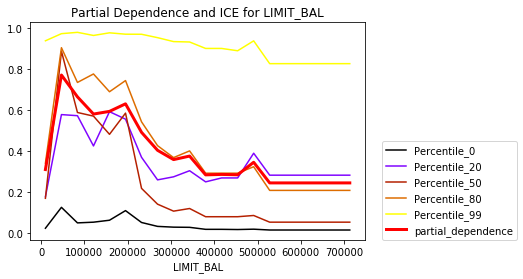

In [20]:
xs='LIMIT_BAL'
plot_par_dep_ICE('LIMIT_BAL', par_dep_LIMIT_BAL) # plot partial dependence and ICE for LIMIT_BAL

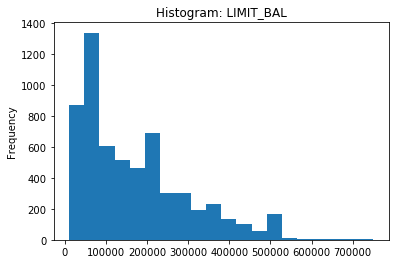

In [21]:
_ = X_test['LIMIT_BAL'].plot(kind='hist', bins=20, title='Histogram: LIMIT_BAL')

# PD and ICE

In [22]:
features

array(['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Total_Bill_Amount',
       'Total_payment_Amount', 'SEX_1', 'SEX_2', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3', 'PAY_0_-2',
       'PAY_0_-1', 'PAY_0_0', 'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4',
       'PAY_0_5', 'PAY_0_6', 'PAY_0_7', 'PAY_0_8', 'PAY_2_-2', 'PAY_2_-1',
       'PAY_2_0', 'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5',
       'PAY_2_6', 'PAY_2_7', 'PAY_2_8', 'PAY_3_-2', 'PAY_3_-1', 'PAY_3_0',
       'PAY_3_1', 'PAY_3_2', 'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6',
       'PAY_3_7', 'PAY_3_8', 'PAY_4_-2', 'PAY_4_-1', 'PAY_4_0', 'PAY_4_1',
       'PAY_4_2', 'PAY_4_3', 'PAY_4_4', 'PAY_4_5', 'PAY_4_6', 'PAY_4_7',
       'PAY_4_8', 'PAY_5_-2', 'PAY_5_-1', 'PAY_5_0', 'PAY_5_2', 'PAY_5_

In [23]:
xs='Total_payment_Amount'

In [24]:
par_dep_frame = par_dep(xs, X_test, clf)
par_dep_frame = par_dep_expand(xs,par_dep_frame)
par_dep_frame.head(5)

,Total_payment_Amount,partial_dependence,Percentile_0,Percentile_20,Percentile_50,Percentile_80,Percentile_99
0,0.00,0.339321,0.016006,0.190118,0.236323,0.545141,0.940147
1,46366.25,0.290566,0.016399,0.139067,0.263372,0.465525,0.938920
2,92732.50,0.274606,0.014980,0.140680,0.220260,0.418189,0.934678
3,139098.75,0.274021,0.014597,0.140680,0.220260,0.418189,0.933056
4,185465.00,0.274839,0.014597,0.140680,0.220260,0.418189,0.933056


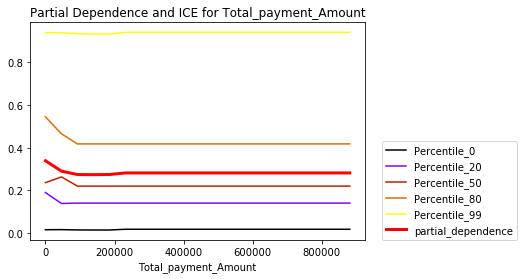

In [25]:
plot_par_dep_ICE(xs, par_dep_frame)

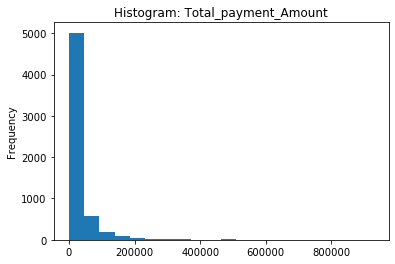

In [26]:
X_test[xs].plot(kind='hist', bins=20, title='Histogram: '+xs)
plt.show()

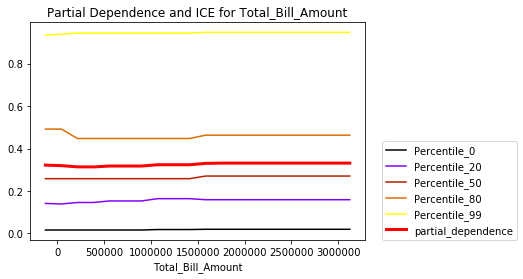

In [27]:
xs='Total_Bill_Amount'
par_dep_frame = par_dep(xs, X_test, clf)
par_dep_frame = par_dep_expand(xs,par_dep_frame)
plot_par_dep_ICE(xs, par_dep_frame)

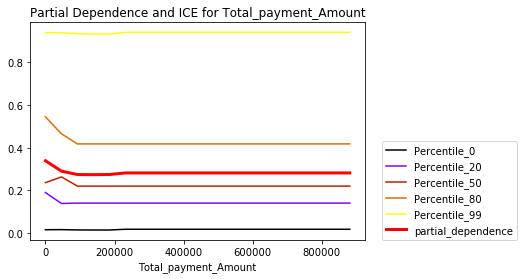

In [28]:
xs='Total_payment_Amount'
par_dep_frame = par_dep(xs, X_test, clf)
par_dep_frame = par_dep_expand(xs,par_dep_frame)
plot_par_dep_ICE(xs, par_dep_frame)

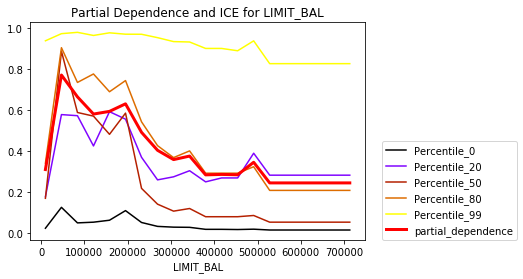

In [29]:
xs='LIMIT_BAL'
par_dep_frame = par_dep(xs, X_test, clf)
par_dep_frame = par_dep_expand(xs,par_dep_frame)
plot_par_dep_ICE(xs, par_dep_frame)

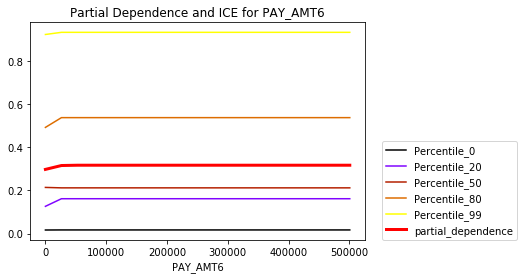

In [30]:
xs='PAY_AMT6'
par_dep_frame = par_dep(xs, X_test, clf)
par_dep_frame = par_dep_expand(xs,par_dep_frame)
plot_par_dep_ICE(xs, par_dep_frame)

# Reason Code

In [31]:
import shap  

explainer = shap.TreeExplainer(clf,X_train, feature_perturbation="interventional")

shap_values = explainer.shap_values(X_test)

 95%|=================== | 5722/6000 [00:21<00:01]       

In [32]:
shap_values.shape

(6000, 146)

In [33]:
def reason_codes(decile):
    '''
    decile = 0,10,20 ,30,40,50,60,70,80,90,99
    '''
    row = X[X['ID'] == percentile_dict[decile]]
    # reset test data index to find riskiest customer in shap_values 
    # sort to find largest positive contributions
    s_df = pd.DataFrame(shap_values[row.index[0], :].reshape(146, 1), columns=['Reason Codes'], index=features)
    s_df.sort_values(by='Reason Codes', inplace=True, ascending=False)

    return s_df

In [34]:
reason_codes(80)

,Reason Codes
PAY_4_2,0.277327
PAY_5_2,0.246421
PAY_AMT2,0.229569
Age_category_>41,0.153820
Age_category_35 - 41,0.152190
...,...
PAY_0_2,-0.140585
PAY_3_0,-0.176568
PAY_AMT6,-0.256573
Age_category_<=28,-0.441510


In [35]:
reason_codes(20)

,Reason Codes
Age_category_35 - 41,0.251071
PAY_0_0,0.234655
Age_category_>41,0.227208
Age_category_29 - 34,0.169653
BILL_AMT1,0.074948
...,...
PAY_0_2,-0.153133
Total_payment_Amount,-0.192942
LIMIT_BAL,-0.626232
PAY_0_-2,-0.655241


# 1D-PDP plot

In [36]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

In [37]:
def PDP_plot_1D(feature_to_plot):
    pdp_dist = pdp.pdp_isolate(model=clf, dataset=X_test, model_features=features, feature=feature_to_plot)
    pdp.pdp_plot(pdp_dist, feature_to_plot)
    plt.show() 

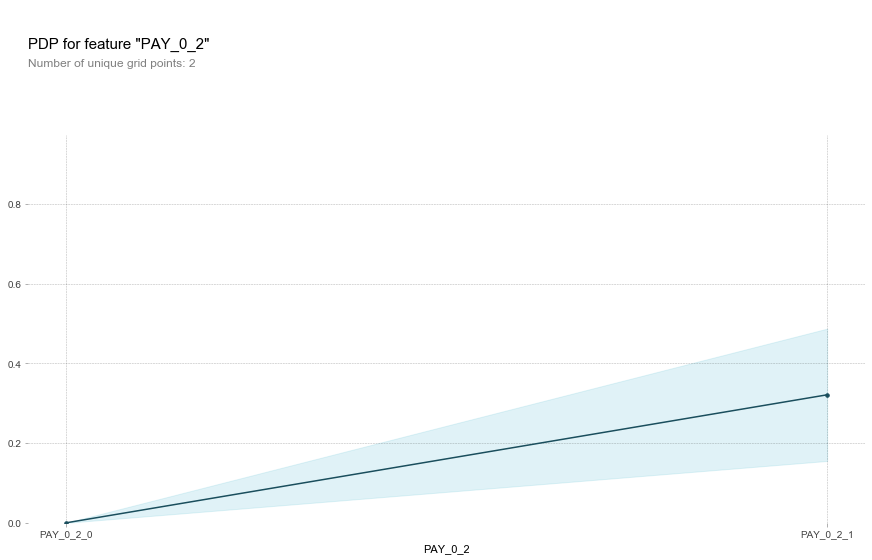

In [38]:
xs='PAY_0_2'
PDP_plot_1D(xs)

# 2D-PDP plot

In [39]:
def PDP_plot_2D(features_to_plot):
    inter = pdp.pdp_interact(model=clf, dataset=X_test,model_features=features,features=features_to_plot)
    pdp.pdp_interact_plot(pdp_interact_out=inter, feature_names=features_to_plot, plot_type='contour')
    plt.show()

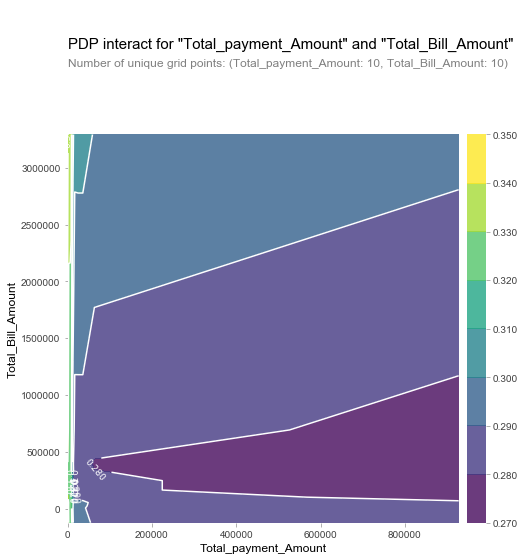

In [40]:
features_to_plot=['Total_payment_Amount', 'Total_Bill_Amount']
PDP_plot_2D(features_to_plot)

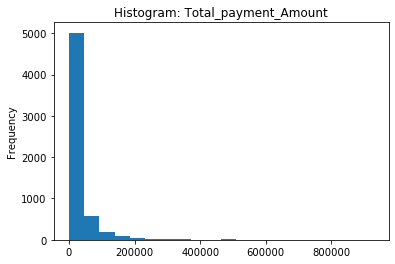

In [41]:
xs='Total_payment_Amount'
X_test[xs].plot(kind='hist', bins=20, title='Histogram: '+xs)
plt.show()

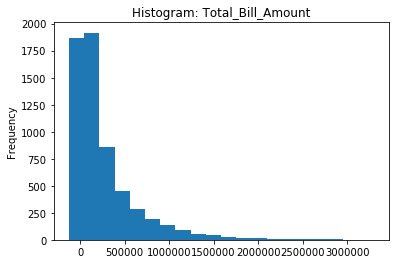

In [42]:
xs='Total_Bill_Amount'
X_test[xs].plot(kind='hist', bins=20, title='Histogram: '+xs)
plt.show()

PAY_0_2
Total_payment_Amount
PAY_AMT6